In [1]:
import pandas as pd
from simulation import Simulation

from models.building_model import BuildingModel
from models.heat_pump import HeatPump
from models.hyst_controller import HystController
from models.weather_model import LocalWeather

%matplotlib widget

In [2]:
sim = Simulation()

building   = BuildingModel('building')
heatpump   = HeatPump('heatpump')
controller = HystController('controller')
weather    = LocalWeather('weather')


sim.add_model(building  )
sim.add_model(heatpump  )
sim.add_model(controller)
sim.add_model(weather   )


sim.connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
sim.connect(weather, heatpump, ('T_air', 'T_source'))
sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(controller, heatpump, ('on', 'on'))

sim.connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
sim.connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

sim.prepare()

# times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

# sim.run(times)

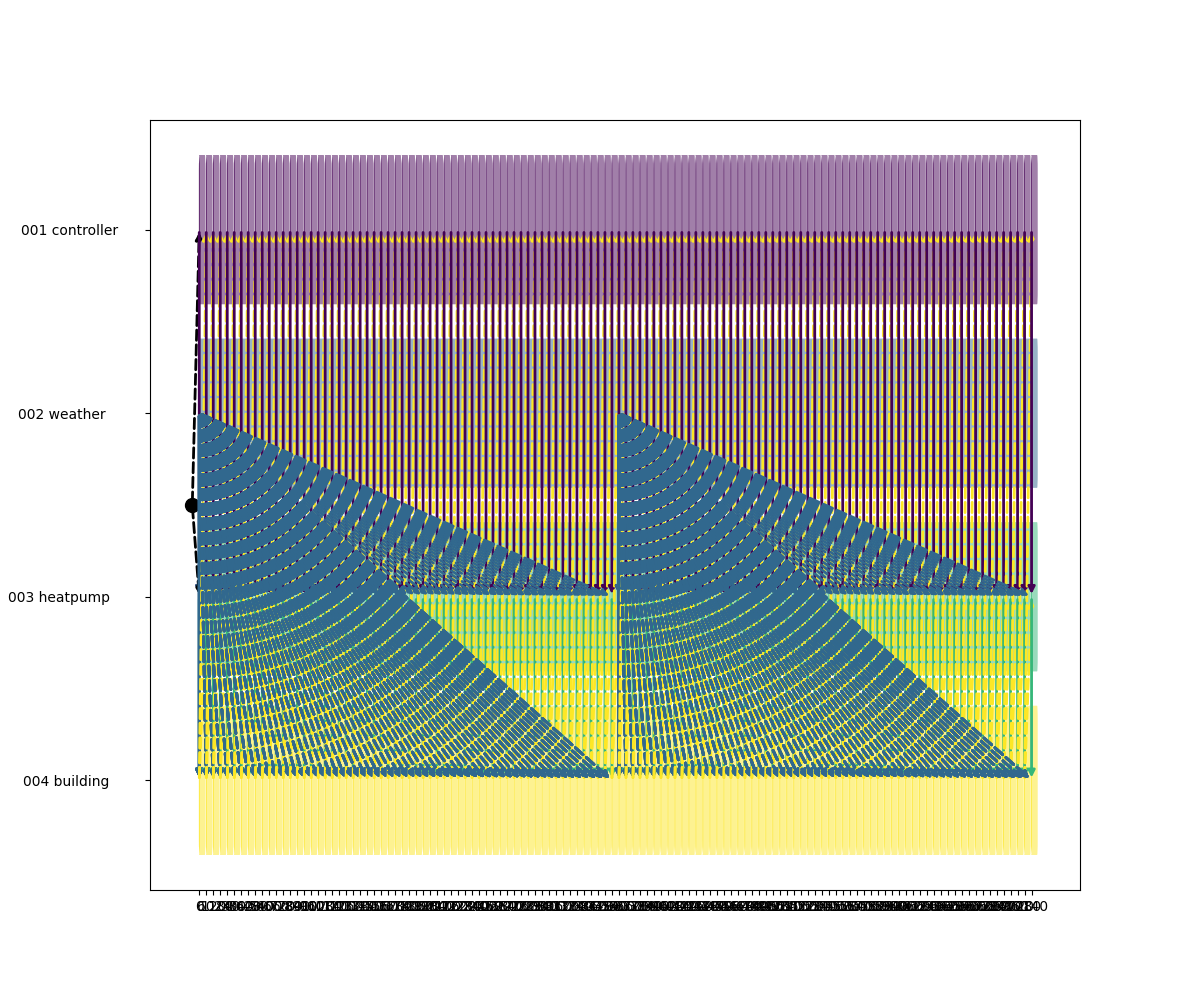

In [3]:
sim.draw_execution_visualization()